In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [9]:
class Classification:
    #TO DO:
    # Raise Error in show accuracy if no classifier was build
    # make the confusion matrix flexible
    # raise Error in upsample function
    
    def __init__(self, dataframe, column_names=[]):
        self.data_splitted = False
        
        if isinstance(dataframe, pd.DataFrame):
            self.data = dataframe
            data_shape = self.data.shape
            print("Classification-Object with",str(data_shape[0]),"samples and",str(data_shape[1]),"columns was created")
        else:
            raise Exception("No pandas dataframe was given!")

        if column_names and len(column_names)==data_shape[1]:
            self.data.columns = column_names
            #Try Catch if not enough column names were given
        elif not column_names:
            print("No column names were given")
        else:
            raise Exception("Number of column names dont match with number of columns!")
    
    def __str__(self):
        pass
    
    def __del__(self):
        pass
    
    def split_train_test(self, y_column_name, test_size=0.2, random_state=0, upsample=False, scaling=False, deleting_na= False):
        from sklearn.model_selection import train_test_split
        from sklearn.preprocessing import StandardScaler
        
        if y_column_name in self.data.columns:
            
            if deleting_na:
                self.data = self.data.dropna(how='all')
                print("Data has been preprocessed!")
            
            self.data_splitted = True
            self._x_data = self.data.copy()
            self._x_train, self._x_test= train_test_split(self._x_data, 
                                                          test_size = test_size, 
                                                          random_state = random_state)
            if upsample:
                self._x_train = self._upsample_dataset(y_column_name)
            
            self._y_train = self._x_train.pop(y_column_name)
            self._y_test = self._x_test.pop(y_column_name)
            

            self._y_train.value_counts().plot(kind="bar",title="Distribution of classification values in the train data set",colormap="gray")
            print("Train data shape:\t"+str(self._x_train.shape)+"\ttrain label shape:\t"+str(self._y_train.shape))
            print("Test data shape:\t"+str(self._x_test.shape)+" \ttest label shape:\t"+str(self._y_test.shape))
            
            if scaling:
                scaler = StandardScaler()
                self._x_train = scaler.fit_transform(self._x_train)
                self._x_test = scaler.transform(self._x_test)
                print("Data has been rescalled!")
            
            

        elif y_column_name not in self.data.columns:
            raise Exception("Given column name was not found in the dataset")
    
    def _upsample_dataset(self,y_column_name):
        
        from sklearn.utils import resample
        count=self._x_train[y_column_name].value_counts(sort=True)
        mask_min = self._x_train[y_column_name].values == count.keys()[-1]
        mask_max = self._x_train[y_column_name].values == count.keys()[0]
        x_train_min = self._x_train.loc[mask_min]
        x_train_max = self._x_train.loc[mask_max]

        x_train_min_upsampled = resample(x_train_min, 
                                        replace=True,
                                        n_samples=x_train_max.shape[0],
                                        random_state=0)
        
        '''
        x_train_max_downsampled = resample(x_train_max, 
                                           replace=True,
                                           n_samples=x_train_min.shape[0],
                                           random_state=0)
        
        downsampled_x_train = pd.concat([x_train_max_downsampled, x_train_min])
        '''
        upsampled_x_train = pd.concat([x_train_max, x_train_min_upsampled])
        
        return upsampled_x_train
        
        
    
    def build_classifier(self, classifier_name, *args):
        from sklearn import metrics
        
        if self.data_splitted:
            if classifier_name == "KNN": #K nearest neighbor
                self.classifier = self._build_knn_classifier(*args)
            elif classifier_name == "SVM": #
                self.classifier = self._build_SVM_classifier(*args)
            elif classifier_name == "LR": 
                self.classifier = self._build_LogisticRegression_classifier(*args)
            else:
                raise Exception("Classifier was not found! Avialable options are KNN (K-Nearest Neighbor), SVM (Support Vector Machine), LR (Logistic Regression)")
            self._y_pred = self.classifier.predict(self._x_test)
            print("A",self.classifier," has been build with an overall accuracy of", round(metrics.accuracy_score(self._y_test, self._y_pred),2))
        else:
            print("The data has to be splitted in train and test data befor a classifier can be build (use the split_train_test command)")
                    
    def _build_knn_classifier(self,k=5):
        from sklearn.neighbors import KNeighborsClassifier
        
        classifier = KNeighborsClassifier(n_neighbors=k)
        return classifier.fit(self._x_train, self._y_train)
    
    def _build_SVM_classifier(self,kernel_fun="linear"):
        from sklearn import svm
        
        classifier = svm.SVC(kernel = kernel_fun)
        return classifier.fit(self._x_train, self._y_train)
        
    def _build_LogisticRegression_classifier(self,solver="liblinear"):
        from sklearn.linear_model import LogisticRegression
        
        classifier = LogisticRegression(solver = solver)
        return classifier.fit(self._x_train, self._y_train)
    
    def show_classifier_accuracy(self):
        from sklearn import metrics
        cnf_matrix = metrics.confusion_matrix(self._y_test, self._y_pred)
        
        for dim in range(cnf_matrix.shape[0]):
            accuracy = cnf_matrix[dim][dim]/sum(cnf_matrix[dim])
            print("Accuracy for the ",dim,"class:", accuracy)
            
        #plot the confusion matrix
        # not felxibale !!!
        class_names=[0,1] 
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        
        # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title(self.classifier,y=1.1)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        #raise Error if no classifier was build yet
        
    def drop_dataframe_column(self, column_name):
        if column_name in self.data.columns:
            self.data.drop([column_name], axis=1, inplace=True)
            print("Column",str(column_name),"was droped, new dataframe:")
            print(data.head())
        else:
            raise Exception("Given column name was not found in the dataset")
    
    def show_correlation(self,figsize=(5,4)):
        corrmat=self.data.corr()

        mask = np.zeros_like(corrmat)
        mask[np.triu_indices_from(mask)] = True

        f, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(corrmat, mask=mask, cmap ="YlGnBu", linewidths = 0.1,fmt = ".2f",annot=True,vmin =-1, vmax=1)
        return 
    
    def get_classifer():
        return self.classifer
    
    ### SOME BASIC DATAFRAME FUNCTIONS 
    def show_dataframe_head(self):
        return self.data.head()
    
    def describe_dataframe(self):
        return self.data.describe()
    
    def show_unique_values(self):
        for column_name in self.data.columns:
            print(column_name)
            print(sorted(self.data[column_name].unique()))
            print()

In [12]:
data = pd.read_csv("transfusion.csv")

column_names = ["Months since Last Donation",
                "Number of Donations",
                "Total Volume Donated (c.c.)",
                "Months since First Donation",
                "Made Donation in March 2007"]

class_obj=Classification(data)

Classification-Object with 748 samples and 5 columns was created
No column names were given


In [13]:
class_obj.describe_dataframe()

,M1,M2,M3,M4,M5
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


Train data shape:	(598, 4)	train label shape:	(598,)
Test data shape:	(150, 4) 	test label shape:	(150,)


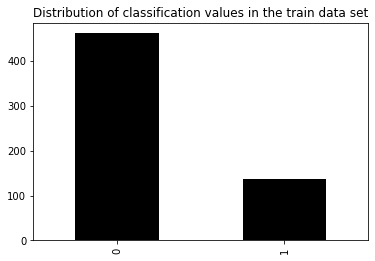

In [14]:
class_obj.split_train_test("M5")

Train data shape:	(922, 4)	train label shape:	(922,)
Test data shape:	(150, 4) 	test label shape:	(150,)


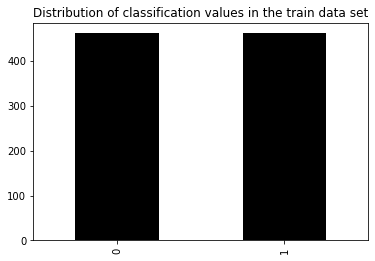

In [6]:
class_obj.split_train_test("Made Donation in March 2007",upsample=True)

In [7]:
class_obj.build_classifier("KNN",k=20)

A KNeighborsClassifier(n_neighbors=20)  has been build with an overall accuracy of 0.71


Accuracy for the  0 class: 0.7247706422018348
Accuracy for the  1 class: 0.6585365853658537


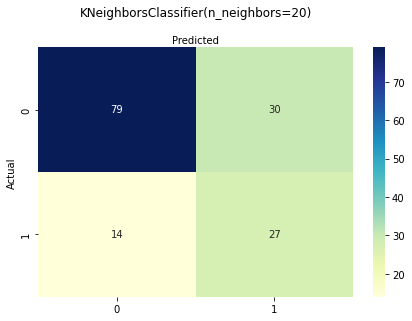

In [8]:
class_obj.show_classifier_accuracy() #recall, precision, f1-score, 

In [9]:
class_obj.build_classifier("LR",solver="liblinear")

A LogisticRegression(solver='liblinear')  has been build with an overall accuracy of 0.68


Accuracy for the  0 class: 0.6330275229357798
Accuracy for the  1 class: 0.8048780487804879


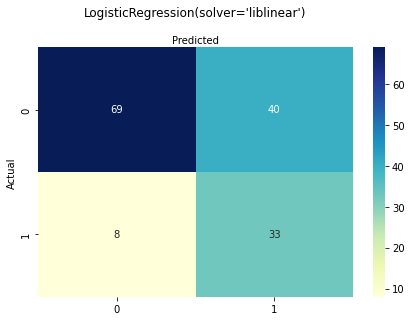

In [10]:
class_obj.show_classifier_accuracy()

In [11]:
class_obj.build_classifier("SVM",kernel_fun="linear")

A SVC(kernel='linear')  has been build with an overall accuracy of 0.65


Accuracy for the  0 class: 0.5779816513761468
Accuracy for the  1 class: 0.8292682926829268


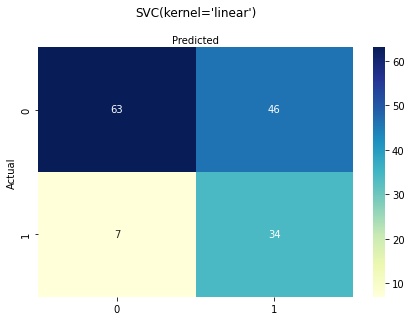

In [12]:
class_obj.show_classifier_accuracy()

In [ ]:
class_obj.build_classifier("KNN",20)
class_obj.build_classifier("LR","liblinear")
class_obj.build_classifier("SVM","linear")
# 

In [11]:
class_obj.build_classifier("KNN",20)

TypeError: build_classifier() takes 2 positional arguments but 3 were given